# Feature Engineering
---------------------

# Imputation Lab
---------------------

In [1]:
conda update pandas

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Now let's bring in the Python libraries that we'll use throughout the analysis

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
import zipfile                                    # to extract zip files contents

In [3]:
pd.__version__

'1.2.4'

Make sure pandas version is set to 1.2.4 or later. If it is not the case, restart the kernel before going further

---

# Data Collection
Let's start by downloading our dataset from the [University of California, irvine dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/)
This is the data set used for The Second International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-98 The Fourth International Conference on Knowledge Discovery and Data Mining. 
The competition task is a regression problem where the goal is to estimate the return from a direct mailing in order to maximize donation profits.

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98lrn.zip

with zipfile.ZipFile('cup98lrn.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

--2022-05-16 18:27:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98lrn.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36468735 (35M) [application/x-httpd-php]
Saving to: ‘cup98lrn.zip.1’

cup98lrn.zip.1      100%[===================>]  34.78M  17.5MB/s    in 2.0s    

2022-05-16 18:27:37 (17.5 MB/s) - ‘cup98lrn.zip.1’ saved [36468735/36468735]



---
The dataset has no column names and therefore we define column names.


Now lets read this into a Pandas data frame and take a look.


The output shows the datatypes

---

In [5]:
cols = ['AGE', 'NUMCHLD', 'INCOME', 'WEALTH1', 'MBCRAFT','MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML','MAGFEM', 'MAGMALE']
data = pd.read_csv('cup98LRN.txt', usecols=cols)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 25)         # Keep the output on one page
data.dtypes

AGE         float64
NUMCHLD     float64
INCOME      float64
WEALTH1     float64
MBCRAFT     float64
MBGARDEN    float64
MBBOOKS     float64
MBCOLECT    float64
MAGFAML     float64
MAGFEM      float64
MAGMALE     float64
dtype: object

Now we can have a look on how the data looks like:

In [6]:
data.head()

,AGE,NUMCHLD,INCOME,WEALTH1,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE
0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,46.0,1.0,6.0,9.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0
2,NaN,NaN,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,70.0,NaN,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.0,1.0,3.0,2.0,1.0,0.0,9.0,0.0,4.0,1.0,0.0


----------------
# Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

,AGE,NUMCHLD,INCOME,WEALTH1,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE
count,71747.000000,12386.000000,74126.000000,50680.000000,42558.000000,42558.000000,42558.000000,42498.000000,42558.000000,42558.000000,42558.000000
mean,61.611649,1.527773,3.886248,5.345699,0.152075,0.059166,1.116382,0.063932,0.448329,0.126322,0.065722
std,16.664199,0.806861,1.854960,2.742490,0.470023,0.262078,1.669967,0.297344,0.821010,0.380916,0.276398
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,2.000000,5.000000,8.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,98.000000,7.000000,7.000000,9.000000,6.000000,4.000000,9.000000,6.000000,9.000000,5.000000,4.000000


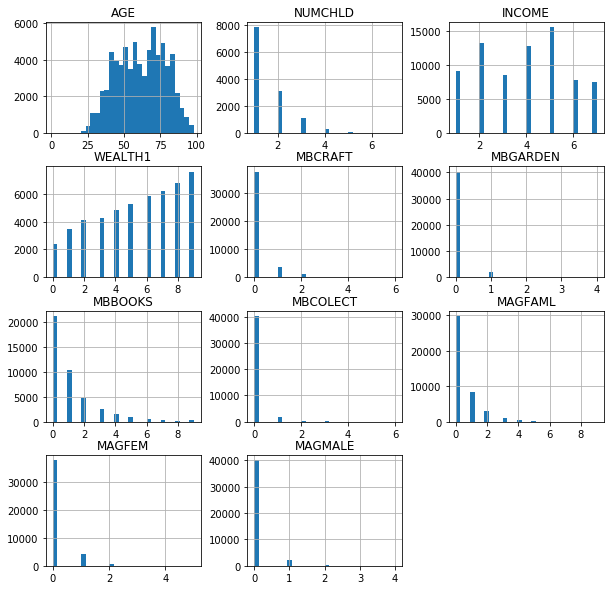

In [7]:
# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=False, figsize=(10, 10))

let's determine the number of unique categories in each variable.


_**The nunique() method ignores missing values by default. If we want to
consider missing values as an additional category, we should set the
dropna argument to False: data.nunique(dropna=False).**_

In [8]:
data.nunique()

AGE         96
NUMCHLD      7
INCOME       7
WEALTH1     10
MBCRAFT      7
MBGARDEN     5
MBBOOKS     10
MBCOLECT     7
MAGFAML      9
MAGFEM       6
MAGMALE      5
dtype: int64

---

Let's calculate the number of missing values in each variable:

---

In [9]:
data.isnull().sum()

AGE         23665
NUMCHLD     83026
INCOME      21286
WEALTH1     44732
MBCRAFT     52854
MBGARDEN    52854
MBBOOKS     52854
MBCOLECT    52914
MAGFAML     52854
MAGFEM      52854
MAGMALE     52854
dtype: int64

Let's quantify the percentage of missing values in each variable:

In [10]:
data.isnull().mean()

AGE         0.248030
NUMCHLD     0.870184
INCOME      0.223096
WEALTH1     0.468830
MBCRAFT     0.553955
MBGARDEN    0.553955
MBBOOKS     0.553955
MBCOLECT    0.554584
MAGFAML     0.553955
MAGFEM      0.553955
MAGMALE     0.553955
dtype: float64

Finally, let's make a bar plot with the percentage of missing values per variable:

Text(0.5, 1.0, 'Quantifying missing data')

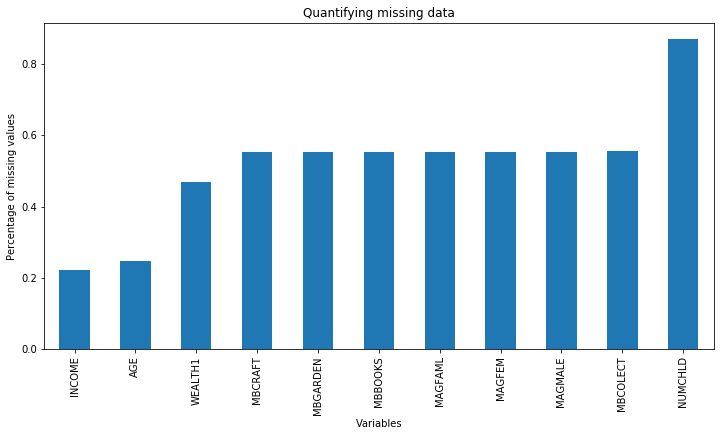

In [11]:
data.isnull().mean().sort_values(ascending=True).plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

------------

# Imputation

## (1) Removing observations with missing data
Now, we'll remove the observations with missing data in any of the variables:

Text(0.5, 1.0, 'Quantifying missing data')

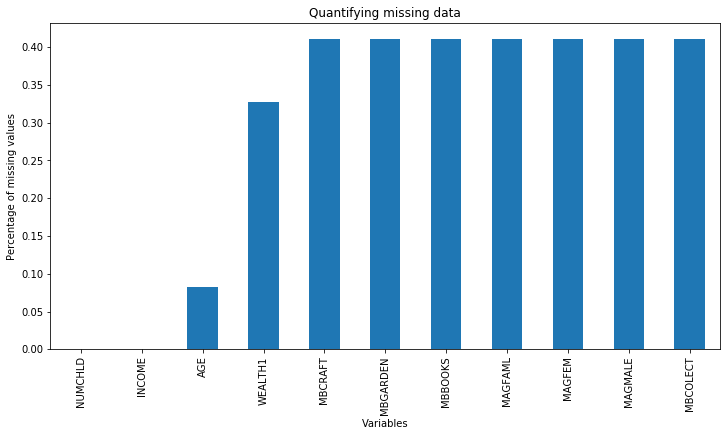

In [12]:
data_cca = data.dropna(subset=['NUMCHLD'])
data_cca.isnull().mean().sort_values(ascending=True).plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

Let's print and compare the size of the original and complete case datasets:

In [13]:
print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases:{}'.format(len(data_cca)))

Number of total observations: 95412
Number of observations with complete cases:12386


Here, we removed observations with missing data as follows:

Number of total observations: 95412

Number of observations with complete cases:12386


## (2) Performing mean or median imputation

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('MBCOLECT', axis=1), data['MBCOLECT'], test_size=0.3,random_state=0)
X_train.shape, X_test.shape

((66788, 10), (28624, 10))

Check the mean of missing values:

In [16]:
X_train.isnull().mean()

AGE         0.248128
NUMCHLD     0.870830
INCOME      0.223034
WEALTH1     0.469366
MBCRAFT     0.554845
MBGARDEN    0.554845
MBBOOKS     0.554845
MAGFAML     0.554845
MAGFEM      0.554845
MAGMALE     0.554845
dtype: float64

Let's replace the missing values with the median in four numerical variables using pandas

In [17]:
for var in ['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MAGFAML']:
    value = X_train[var].median()
    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)

Now check the mean of missing values and notice the change

In [18]:
X_train.isnull().mean()

AGE         0.248128
NUMCHLD     0.870830
INCOME      0.223034
WEALTH1     0.469366
MBCRAFT     0.000000
MBGARDEN    0.000000
MBBOOKS     0.000000
MAGFAML     0.000000
MAGFEM      0.554845
MAGMALE     0.554845
dtype: float64

To impute missing data with the mean, we use pandas' mean():value = X_train[var].mean().

### (3) Mean or Median Imputaion with scikit-learn

SimpleImputer() from scikit-learn will impute all variables in the
dataset. Therefore, if we use mean or median imputation and the dataset
contains categorical variables, we will get an error.

In [19]:
imputer = SimpleImputer(strategy='median')
imputer.fit(data)
imputer.statistics_

array([62.,  1.,  4.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Let's replace missing values with medians:

In [20]:
impute_data_array = imputer.transform(data)

In [21]:
data_after_impute=pd.DataFrame(impute_data_array, columns =cols)
data_after_impute.head()

,AGE,NUMCHLD,INCOME,WEALTH1,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE
0,60.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46.0,1.0,6.0,9.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0
2,62.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,70.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.0,1.0,3.0,2.0,1.0,0.0,9.0,0.0,4.0,1.0,0.0


----------------

# Data Wrangler

Prepare for Data Wrangler by uploading dataset to S3 - Make sure to change the bucket name to your own prefered bucket

In [22]:
import boto3

your_bucket = 'imputation-lab-19112021'

boto3.Session().resource('s3').Bucket(your_bucket).Object(os.path.join('KDDCup', 'cup98LRN.txt')).upload_file('cup98LRN.txt')

Now Goto Data Wrangler